In [2]:
!pip install --upgrade jieba==0.39 --proxy http://web-proxy.rose.hp.com:8080  
!pip install --upgrade keras==2.1.6 --proxy http://web-proxy.rose.hp.com:8080  
!pip install --upgrade sklearn==0.19.1 --proxy http://web-proxy.rose.hp.com:8080   
!pip install --upgrade gensim==3.4.0 --proxy http://web-proxy.rose.hp.com:8080  
!pip install --upgrade pytorch==0.4.0 --proxy http://web-proxy.rose.hp.com:8080

    100% |################################| 7.3MB 186kB/s eta 0:00:01
  Running setup.py bdist_wheel for jieba ... done
  Stored in directory: /root/.cache/pip/wheels/c9/c7/63/a9ec0322ccc7c365fd51e475942a82395807186e94f0522243
Successfully built jieba
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |################################| 348kB 3.0MB/s eta 0:00:01
    100% |################################| 2.7MB 481kB/s eta 0:00:01
    100% |################################| 13.8MB 86kB/s eta 0:00:011
    100% |################################| 30.8MB 45kB/s eta 0:00:011
Requirement already up-to-date: six>=1.9.0 in /usr/local/lib/python2.7/dist-packages (from keras==2.1.6)
    100% |################################| 276kB 3.0MB/s eta 0:00:01
  Running setup.py bdist_wheel for pyyaml ... done
  Stored in directory: /root/.cache/pip/wheels/ad/da/0c/74eb680767247273e2cf2723482cb9c924fe70af5

    100% |################################| 552kB 2.1MB/s eta 0:00:01
  Running setup.py bdist_wheel for smart-open ... done
  Stored in directory: /root/.cache/pip/wheels/23/00/44/e5b939f7a80c04e32297dbd6d96fa3065af89ecf57e2b5f89f
  Running setup.py bdist_wheel for bz2file ... done
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file
  Found existing installation: certifi 2018.1.18
    Uninstalling certifi-2018.1.18:
      Successfully uninstalled certifi-2018.1.18
  Found existing installation: python-dateutil 2.6.1
    Uninstalling python-dateutil-2.6.1:
      Successfully uninstalled python-dateutil-2.6.1
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Could not find a version that satisfies the requirement pytorch==0.4.0 (from versions: 0.1.2)
No matching distribution found for pytorch==0.4.0
Yo

In [1]:
import jieba
import sys
import numpy as np
import keras
import keras.backend as K
import pandas as pd

import pickle
import sklearn
import codecs
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras import layers as L
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter, defaultdict


pd.set_option('display.width', 1000)

print(keras.__version__)
print(pd.__version__)
print(np.__version__)
print(sklearn.__version__)

stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

BATCH_SIZE=64

Using TensorFlow backend.


2.1.6
0.22.0
1.15.1
0.19.1


Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.286 seconds.
Prefix dict has been built succesfully.


In [2]:
import locale, sys
print(sys.getdefaultencoding())    #系统默认编码
print(sys.getfilesystemencoding()) #文件系统编码
print(locale.getdefaultlocale())   #系统当前编码
print(sys.stdin.encoding)          #终端输入编码
print(sys.stdout.encoding)         #终端输出编码



utf-8
ANSI_X3.4-1968
(None, None)
None
UTF-8


In [3]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

## 1. 数据

### 1.1 加载数据和分词

In [4]:

def process(inpath, outpath):
    with open(inpath, 'r') as fin, open(outpath, 'w') as fout:
        for line in fin:
            lineno, sen1, sen2 = line.strip().split('\t')
            words1= [ w for w in jieba.cut(sen1) if w.strip() ]
            words2= [ w for w in jieba.cut(sen2) if w.strip() ]
            union = words1 + words2
            same_num = 0
            for w in union:
                if w in words1 and w in words2:
                    same_num += 1
            if same_num * 2 >= len(union):
                fout.write(lineno + '\t1\n')
            else:
                fout.write(lineno + '\t0\n')


def load_data(filepath):
    data = []
    with open(filepath, 'r') as f:
        i = 0 
        for line in f:
            lineno, sent1, sent2, tag = line.strip().split('\t')
            data.append((lineno, sent1, sent2, tag))
    return data      


def split_sentence(sentence):
    return [w for w in jieba.cut(sentence) if w.strip() ]

# def split_sentence(sentence):
#     return [w for w in sentence.decode('utf-8') if w.strip() ]


def segmentation(data, split=split_sentence, userwords_filepath='words.txt', stupwords_filepath='stopwords.txt'):
    jieba.load_userdict(userwords_filepath) 
    new_data = []
    for  (lineno, sen1, sen2, tag) in data:
        words1 = split(sen1)
        words2 = split(sen2)
        new_data.append((lineno, words1, words2, tag))
    return new_data


# 创建停用词list  
def stopwordslist(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r').readlines()]  
    return stopwords  


# 对句子进行分词  
def remove_stopwords(data, ):  
    sentence_seged = jieba.cut(sentence.strip())  
    stopwords = stopwordslist('./test/stopwords.txt')  # 这里加载停用词的路径  
    outstr = ''  
    for word in sentence_seged:  
        if word not in stopwords:  
            if word != '\t':  
                outstr += word  
                outstr += " "  
    return outstr  


def print_unicode(text):
    print(repr(text).decode('unicode_escape'))
    
def print_utf8(text):
    print(repr(text).decode('string_escape'))    


data_raw = load_data('./data/atec_nlp_sim_train.csv') + load_data('./data/atec_nlp_sim_train_add.csv')
print(len(data_raw))

102477


In [5]:
for  (lineno, sen1, sen2, tag) in data_raw[0:2]:
    print_utf8((sen1, sen2))
    for word in sen1.decode('utf-8'):
        print_utf8(word)

('怎么更改花呗手机号码', '我的花呗是以前的手机号码，怎么更改成现在的支付宝的号码手机号')
u'\u600e'
u'\u4e48'
u'\u66f4'
u'\u6539'
u'\u82b1'
u'\u5457'
u'\u624b'
u'\u673a'
u'\u53f7'
u'\u7801'
('也开不了花呗，就这样了？完事了', '真的嘛？就是花呗付款')
u'\u4e5f'
u'\u5f00'
u'\u4e0d'
u'\u4e86'
u'\u82b1'
u'\u5457'
u'\uff0c'
u'\u5c31'
u'\u8fd9'
u'\u6837'
u'\u4e86'
u'\uff1f'
u'\u5b8c'
u'\u4e8b'
u'\u4e86'


In [6]:

data = segmentation(data_raw)   

In [7]:
#去除字符乱码
print_unicode(data[0])   
data[0]=('1', data[0][1], data[0][2], data[0][3])

print_utf8(data_raw[3])
print_unicode(data[3][1])

('ï»¿1', [u'怎么', u'更改', u'花呗', u'手机号码'], [u'我', u'的', u'花呗', u'是', u'以前', u'的', u'手机号码', u'，', u'怎么', u'更', u'改成', u'现在', u'的', u'支付宝', u'的', u'号码', u'手机号'], '1')
('4', '如何得知关闭借呗', '想永久关闭借呗', '0')
[u'如何', u'得知', u'关闭', u'借呗']


In [8]:
word_counts = Counter()
for (_, sent1, sent2, _) in data:   
    word_counts.update(sent1)
    word_counts.update(sent2)
print(len(word_counts), len(data)) 
print_unicode(word_counts.most_common(100))

low_freq_words = [word for word, count in word_counts.items() if count==3] 
print('three-occur word: ',len(low_freq_words))  #8960  total:13419
print_unicode(low_freq_words[0:10])

low_freq_words = [word for word, count in word_counts.items() if count==2] 
print('two-occur word: ',len(low_freq_words))  #1690  total:13419
print_unicode(low_freq_words[0:10])

low_freq_words = [word for word, count in word_counts.items() if count==1] 
print('one-occur word: ', len(low_freq_words))  #6423  total:13419
print_unicode(low_freq_words[0:10])

one_freq_words = low_freq_words

#分词的一些问题：  ('我用', 2051)

(13420, 102477)
[(u'花呗', 149045), (u'我', 61737), (u'借呗', 61340), (u'的', 60190), (u'*', 50301), (u'了', 47471), (u'，', 46908), (u'吗', 42196), (u'还', 35112), (u'怎么', 33715), (u'还款', 31820), (u'可以', 28454), (u'蚂蚁', 28414), (u'用', 26203), (u'为什么', 25282), (u'额度', 21894), (u'是', 17433), (u'分期', 17117), (u'开通', 17104), (u'不能', 12605), (u'钱', 12563), (u'能', 12168), (u'没有', 12015), (u'有', 11703), (u'不', 11692), (u'什么', 11164), (u'使用', 10375), (u'在', 9932), (u'支付宝', 9045), (u'不了', 8260), (u'付款', 7615), (u'支付', 7530), (u'月', 7407), (u'到', 7167), (u'多少', 7021), (u'逾期', 6793), (u'显示', 6453), (u'提前', 6266), (u'会', 6247), (u'现在', 6225), (u'没', 5603), (u'银行卡', 5451), (u'退款', 5396), (u'后', 5376), (u'余额', 5344), (u'时候', 5280), (u'收款', 5151), (u'自动', 5109), (u'申请', 5082), (u'关闭', 4805), (u'这个', 4795), (u'要', 4740), (u'和', 4634), (u'借', 4609), (u'如何', 4541), (u'么', 4417), (u'已经', 4378), (u'怎么办', 4354), (u'一个', 4122), (u'都', 4110), (u'账单', 3917), (u'买', 3851), (u'淘宝', 3801), (u'影响', 3739), (u'临时', 3681), (

从上面结果可以看出，低频词特别多，其中只出现一次的词高达6423，几乎占了所有词汇的一半以上。

**数据分成train, validation**

In [9]:
X_all = [(sent1, sent2)  for (_, sent1, sent2, _) in data] 
y_all = np.array([tag  for (_, _, _, tag) in data]).astype(int)

X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.3, random_state=42)
print(len(X_all), len(y_all))
print(len(X_train), len(y_train))
print(len(X_val), len(y_val))
print_unicode(X_train[0])


(102477, 102477)
(71733, 71733)
(30744, 30744)
([u'我', u'的', u'来', u'分期', u'评估', u'和', u'支付宝', u'评估', u'两者', u'是', u'一样', u'的', u'评估', u'么'], [u'我用', u'支付宝', u'买', u'东西', u'也', u'蛮', u'多', u'的'])


('max length =', 90)


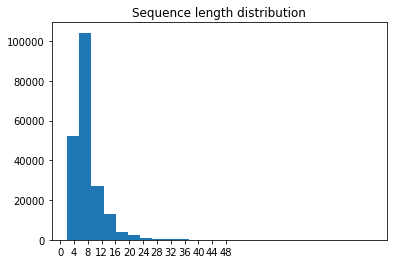

In [10]:
sents_all = [sent for (sent, _) in X_all] + [sent for (_, sent) in X_all]    
MAX_LENGTH = max(map(len, sents_all))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.xticks(np.linspace(0,48,13,endpoint=True))
plt.hist(list(map(len,sents_all)),bins=25);


上图可以看出，大部分的句子长度在8个长度左右。

In [11]:
word_counts = Counter()
for (sent1, sent2) in X_train:   
    word_counts.update(sent1)
    word_counts.update(sent2)
    
low_freq_words = [word for word, count in word_counts.items() if count==1] 
print('one-occur word: ', len(low_freq_words))  #6423  total:13419
print_unicode(low_freq_words[0:10])

one_freq_words = low_freq_words   

('one-occur word: ', 5492)
[u'只得', u'有发', u'填完', u'过日子', u'二立', u'选泽', u'银子', u'吸', u'号通', u'禁言']


In [12]:
print(y_all.shape)
y_bin = np.bincount(y_all)
ii = np.nonzero(y_bin)[0]
print(np.vstack((ii,y_bin[ii])).T)

(102477,)
[[    0 83792]
 [    1 18685]]


从上面的结果来看数据的倾斜非常厉害。

### 1.2 矩阵化

In [13]:
# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"


def generate_vocabulary(X_train, min_occur_count=5):    
    words = [ word for (sent, _)  in X_train for word in sent  ] + [ word for (_, sent)  in X_train for word in sent  ] 
    vocab = Counter(words)
    vocab = [PAD, UNK, START, END] + [word for word, count in vocab.items() if count>=min_occur_count ] 
    return {token: index for index, token in enumerate(sorted(vocab))}

def tokens_to_indices(X, vocab):    
    matrix_1 = [[vocab.get(word, vocab[UNK]) for word in sent] for (sent, _)  in X] 
    matrix_2 = [[vocab.get(word, vocab[UNK]) for word in sent] for (_, sent)  in X]     
    return matrix_1, matrix_2

def to_matrix(X_indexed, pad=0, max_len=None, dtype='int32'):
    if max_len  is None:
        max_len = max(map(len, X_indexed[0]) + map(len, X_indexed[1]))
    else:
        max_len = min(max_len, max(map(len, X_indexed[0]) + map(len, X_indexed[1])))    
        
    max_len = max_len or max(map(len, X_indexed[0]) + map(len, X_indexed[1]))
    matrix1 = np.empty([len(X_indexed[0]),max_len],dtype)
    matrix2 = np.empty([len(X_indexed[1]),max_len],dtype)
    matrix1.fill(pad)
    matrix2.fill(pad)
    
    for i in range(len(X_indexed[0])):
        line_ix = X_indexed[0][i][:max_len]
        matrix1[i,:len(line_ix)] = line_ix
        
    for i in range(len(X_indexed[1])):
        line_ix = X_indexed[1][i][:max_len]
        matrix2[i,:len(line_ix)] = line_ix    
    return matrix1, matrix2    


In [14]:
vocab = generate_vocabulary(X_train, min_occur_count=1)
vocab_inverse = {idx: w for w, idx in vocab.items()}

In [15]:
print(len(vocab))
print_unicode(list(vocab)[0:5])
# print(vocab[PAD], vocab[UNK], vocab[START], vocab[END], vocab[u"花呗"], vocab[u"借呗"], vocab[u"开通"], vocab[u"支付宝"])

11372
[u'有变', u'付会收', u'星期一', u'有发', u'出来']


In [16]:
# index化。
X_train_indexed = tokens_to_indices(X_train, vocab)
X_val_indexed = tokens_to_indices(X_val, vocab)
X_sample_indexed = tokens_to_indices(X_train[0:3], vocab)

In [17]:

for i in range(len(X_sample_indexed[0])):
    print('-----------------------------------------')
    sent1 = [vocab_inverse[index] for index in X_sample_indexed[0][i]]
    sent2 = [vocab_inverse[index] for index in X_sample_indexed[1][i]]
    print_unicode(sent1)
    print_unicode(sent2)
    print_unicode(X_train[i][0])
    print_unicode(X_train[i][1])
  
    
#检查一下，是否一些低频词被替换成#UNK#。
def filter_by_word(X, word):
    indices = [i for i,(sent1, sent2) in enumerate(X) if word in sent1 or word in sent2]
    return indices

def show_words(X_indexed, indice):
    sent1 = [ vocab_inverse[i] for i in X_indexed[0][indice]] 
    sent2 = [ vocab_inverse[i] for i in X_indexed[1][indice]] 
    print_unicode((sent1, sent2))

print('=========================================')  
print_unicode(one_freq_words[0:10])  # [u'只得', u'有发', u'填完', u'过日子', u'二立', u'选泽', u'银子', u'吸', u'号通', u'禁言']
# indice = filter_by_word(X_train, u'过日子')[0]
# print_unicode(X_train[indice])
# show_words(X_train_indexed, indice)
# print(X_train_indexed[0][indice], X_train_indexed[1][indice])

print('=========================================') 


X_train_seq = to_matrix(X_train_indexed, max_len=12, pad=vocab[PAD])
X_val_seq = to_matrix(X_val_indexed, max_len=12, pad=vocab[PAD])
X_sample_seq = to_matrix(X_sample_indexed, max_len=12, pad=vocab[PAD])


for i in range(len(X_sample_indexed[0])):
    print('-----------------------------------------')
    sent1 = [index for index in X_sample_indexed[0][i]]
    sent2 = [index for index in X_sample_indexed[1][i]]
    sent11 = [index for index in X_sample_seq[0][i]]
    sent21 = [index for index in X_sample_seq[1][i]]    
    print_unicode(sent1)
    print_unicode(sent2)
    print_unicode(sent11)
    print_unicode(sent21)

-----------------------------------------
[u'我', u'的', u'来', u'分期', u'评估', u'和', u'支付宝', u'评估', u'两者', u'是', u'一样', u'的', u'评估', u'么']
[u'我用', u'支付宝', u'买', u'东西', u'也', u'蛮', u'多', u'的']
[u'我', u'的', u'来', u'分期', u'评估', u'和', u'支付宝', u'评估', u'两者', u'是', u'一样', u'的', u'评估', u'么']
[u'我用', u'支付宝', u'买', u'东西', u'也', u'蛮', u'多', u'的']
-----------------------------------------
[u'身份证', u'过期', u'借呗', u'是不是', u'额度', u'没', u'办法', u'用']
[u'我', u'的', u'身份证', u'过期', u'了', u'为什么', u'不能', u'办', u'蚂蚁', u'借呗']
[u'身份证', u'过期', u'借呗', u'是不是', u'额度', u'没', u'办法', u'用']
[u'我', u'的', u'身份证', u'过期', u'了', u'为什么', u'不能', u'办', u'蚂蚁', u'借呗']
-----------------------------------------
[u'借呗', u'提前', u'还款', u'后', u'没', u'额度', u'什么', u'原因']
[u'借呗', u'提前', u'还款', u'没有', u'额度', u'了', u'，', u'都', u'好几个', u'月', u'都', u'出不来', u'了']
[u'借呗', u'提前', u'还款', u'后', u'没', u'额度', u'什么', u'原因']
[u'借呗', u'提前', u'还款', u'没有', u'额度', u'了', u'，', u'都', u'好几个', u'月', u'都', u'出不来', u'了']
[u'只得', u'有发', u'填完', u'过日子', u'二立', u'选泽', 

### 1.2 BOW(bag-of-words)

#### 1.2.1 TF-IDF

In [18]:
def tfidf_vectorize(X_train):
    corpus = [" ".join(sent) for (sent, _) in X_train] + [" ".join(sent) for (_, sent) in X_train]
    print(corpus[0:10])
    vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b")
    vectorizer.fit(corpus) 
    return vectorizer

def tfidf_to_matrix(X, vectorizer):
    corpus_list1 = [" ".join(sent) for (sent, _) in X]
    corpus_list2 = [" ".join(sent) for (_, sent) in X]
    matrix_1 = vectorizer.transform(corpus_list1)
    matrix_2 = vectorizer.transform(corpus_list2)
    return matrix_1, matrix_2

vectorizer= tfidf_vectorize(X_train)  
X_train_tfidf = tfidf_to_matrix(X_train, vectorizer)
X_val_tfidf = tfidf_to_matrix(X_val, vectorizer)


[u'\u6211 \u7684 \u6765 \u5206\u671f \u8bc4\u4f30 \u548c \u652f\u4ed8\u5b9d \u8bc4\u4f30 \u4e24\u8005 \u662f \u4e00\u6837 \u7684 \u8bc4\u4f30 \u4e48', u'\u8eab\u4efd\u8bc1 \u8fc7\u671f \u501f\u5457 \u662f\u4e0d\u662f \u989d\u5ea6 \u6ca1 \u529e\u6cd5 \u7528', u'\u501f\u5457 \u63d0\u524d \u8fd8\u6b3e \u540e \u6ca1 \u989d\u5ea6 \u4ec0\u4e48 \u539f\u56e0', u'\u82b1\u5457 \u90fd \u662f \u53ef\u4ee5 \u7528', u'\u82b1\u5457 \u7528 \u4e0d\u4e86', u'\u6211 \u5df2\u7ecf \u8fd8 \u5b8c \u82b1\u5457 \u4e86 \uff0c \u90a3 \u706b\u8f66\u7968 \u9000\u6b3e \u53bb \u54ea\u91cc \u4e86', u'\u501f\u5457 \u6700 \u665a \u591a\u957f\u65f6\u95f4 \u8fd8', u'\u5f00\u901a \u4e86 \u4fe1\u7528\u5361 \u6536\u6b3e \u600e\u4e48 \u8fd8\u662f \u4e0d\u80fd \u7528', u'\u6211 \u7684 \u82b1\u5457 \u65e0\u6cd5 \u626b\u7801 \u652f\u4ed8 \uff0c \u6240\u6709 \u7684 \u5e97\u94fa \u90fd \u65e0\u6cd5 \u652f\u4ed8', u'\u6211 \u82b1\u5457 \u6ca1\u6709 \u4e34\u65f6 \u989d\u5ea6 \u538b']


In [19]:
import math

def save_object(obj, filename):
    with open(filename, 'wb') as output: 
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        
def load_object(filename):        
    with open(filename, 'rb') as input:
        obj = pickle.load(input)        
    return obj
        
save_object(X_train, 'X_train.pkl')

X_train_load  = load_object('X_train.pkl')
print_unicode(X_train[0])
print_unicode(X_train_load[0])

# file_X_train = open('X_train.obj', 'w')
# pickle.dump(X_train, file_X_train)

([u'我', u'的', u'来', u'分期', u'评估', u'和', u'支付宝', u'评估', u'两者', u'是', u'一样', u'的', u'评估', u'么'], [u'我用', u'支付宝', u'买', u'东西', u'也', u'蛮', u'多', u'的'])
([u'我', u'的', u'来', u'分期', u'评估', u'和', u'支付宝', u'评估', u'两者', u'是', u'一样', u'的', u'评估', u'么'], [u'我用', u'支付宝', u'买', u'东西', u'也', u'蛮', u'多', u'的'])


In [20]:
print(X_train_tfidf[0].shape, X_train_tfidf[1].shape)
print(X_val_tfidf[0].shape, X_val_tfidf[1].shape)

((71733, 11297), (71733, 11297))
((30744, 11297), (30744, 11297))


In [21]:
#查看tfidf后的结果
def show_sentence(X, y, X_tfidf, words, items=range(10), y_pred=None, a_pred=None):
    for i in items:
        print('------------------------row %d------------------------' % (i))
        print("sent1: {} \nsent2: {} ".format(''.join(X[i][0]), ''.join(X[i][1])) )
        if y_pred is None:
            print("y = {}".format(y[i]))
        else:
            print("y = {}, y_pred = {}, a_pred= {}".format(y[i], y_pred[i], a_pred[i]))
        sent1_tfidf, sent2_tfidf = [], []
        for j in range(len(words)):
            if X_tfidf[0][i,j] >= 1e-10: sent1_tfidf.append(words[j] + "=" + '{:.8f}'.format(X_tfidf[0][i,j]))
            if X_tfidf[1][i,j] >= 1e-10: sent2_tfidf.append(words[j] + "=" + '{:.8f}'.format(X_tfidf[1][i,j]))
        print('tfidf1: {}'.format(', '.join(sent1_tfidf)))
        print('tfidf2: {}'.format(', '.join(sent2_tfidf)))

words = vectorizer.get_feature_names()
show_sentence(X_train, y_train,  X_train_tfidf, words, items=np.arange(0, 6000, 400))

------------------------row 0------------------------
sent1: 我的来分期评估和支付宝评估两者是一样的评估么 
sent2: 我用支付宝买东西也蛮多的 
y = 0
tfidf1: 一样=0.22444348, 两者=0.42605797, 么=0.17509544, 分期=0.12893940, 和=0.17351256, 我=0.08470678, 支付宝=0.15173236, 是=0.12693644, 来=0.24532790, 的=0.17120391, 评估=0.74491743
tfidf2: 东西=0.31149912, 也=0.31587926, 买=0.28584534, 多=0.33230920, 我用=0.32171005, 支付宝=0.23985517, 的=0.13531768, 蛮=0.65704863
------------------------row 400------------------------
sent1: 花呗有没有像信用卡那样最后还款日后三天还都不算逾期，也没费用 
sent2: 我花呗逾期了，现在工资还没发，能不能宽限几天 
y = 0
tfidf1: 三天=0.31012129, 不算=0.32751496, 也=0.20227695, 信用卡=0.19136015, 像=0.33376436, 日后=0.39104723, 最后=0.26988303, 有没有=0.24449551, 没=0.16910407, 花呗=0.04964531, 费用=0.24412517, 还=0.10588056, 还款=0.10698801, 逾期=0.16214070, 那样=0.38718825, 都=0.18048036
tfidf2: 不能=0.17940157, 了=0.12281289, 几天=0.31638647, 宽限=0.46113720, 工资=0.50057764, 我=0.11085712, 没发=0.48137780, 现在=0.21368438, 能=0.18146917, 花呗=0.06418411, 还=0.13688804, 逾期=0.20962416
------------------------row 800--------

In [22]:

def get_indices(y_index, batch_size):
    indices = np.random.permutation(np.arange(len(y_index)))
    return list(y_index[indices[0:batch_size]] )

#尝试随机的得到label比例是1：1的batch数据， 不知道这样是覅偶可以有做帮助数据倾斜的问题。
#看来这招还挺有用，val f1很快从0.25提高到0.36
#random_sent 无论是true, false, 对结果影响不是很大。
def generate_batches_tfidf(X, y, batch_size=BATCH_SIZE, positive_ratio=0.5, random_sent=True):  
    while True:
        y_index_1 = np.array([i for i,label in enumerate(y) if label==1])
        y_index_0 = np.array([i for i,label in enumerate(y) if label==0])

        y_index_1_batch_size = int(batch_size*positive_ratio)
        y_index_0_batch_size = batch_size - y_index_1_batch_size
        
        for start in range(0,len(y)-1,batch_size):
            index = np.random.permutation(np.arange(2)) if random_sent else np.arange(2)
            batch_indices = get_indices(y_index_1, y_index_1_batch_size) + get_indices(y_index_0, y_index_0_batch_size)
            yield [X[index[0]][batch_indices].toarray(), X[index[1]][batch_indices].toarray()], y[batch_indices]  


## 2. 模型

下面是自己写的一个求f1_score, precison, recall, accuracy的类，应该可以用sklearn里面的相同功能替换。

In [23]:
class Predictor(object):
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        A = self.model.predict(X)
        return self.predict_(A)

    def predict_(self, A):
        return A
    

class ClassificationPredictor(Predictor):

    def __init__(self, model):
        Predictor.__init__(self, model)

    def predict_(self, A):
        if A.shape[1]== 1:
            return np.int32(A > 0.5).flatten()
        else: 
            return  np.argmax(A, axis=-1)

    def accuracy(self, X, y):
        y_pred = self.predict(X)
        return self.accuracy_(y_pred, y)

    def accuracy_(self, y_pred, y):
        return np.mean(y_pred == y)

    def evaluate(self, X, y, title=""):
        y_pred = self.predict(X)
        accuracy = self.accuracy_(y_pred, y)

        metrics = []

        tp = np.sum((y_pred==1) * (y==1))*1.0
        fn = np.sum((y_pred==0) * (y==1))*1.0
        fp = np.sum((y_pred==1) * (y==0))*1.0
        tn = np.sum((y_pred==0) * (y==0))*1.0

        recall = tp/(tp+fn) if tp>0 else 0
        precision = tp/(tp+fp) if tp>0 else 0
        specificity = tn/(tn+fp) if tn>0 else 0
        f1 = 2*recall*precision/(recall+precision) if recall+precision>0 else 0

        metrics.append([accuracy, recall, precision, specificity, f1, tp, fn, fp, tn])

        metrics = pd.DataFrame(metrics, index=[title],
                               columns=['accuracy', 'recall', 'precision', 'specificity', 'f1',  'tp', 'fn', 'fp', 'tn'])
        return metrics

    def print_metrics(self, train_X, train_y, dev_X=None, dev_y=None, test_X=None, test_y=None):
        metrics = []
        if train_X is not None:
            metrics_ = self.evaluate(train_X, train_y)
            metrics_.index=["train"]
            metrics.append(metrics_)
        if dev_X is not None:
            metrics_ = self.evaluate(dev_X, dev_y)
            metrics_.index = ["dev"]
            metrics.append(metrics_)
        if test_X is not None:
            metrics_ = self.evaluate(test_X, test_y)
            metrics_.index = ["test"]
            metrics.append(metrics_)
        print(pd.concat(metrics))

    def print_accuracy(self, X, y, title="train"):
        print("{} accuracy: {}".format(title, self.accuracy(X, y)))

    def print_accuracy_train_test(self, train_X, train_y, dev_X=None, dev_y=None, test_X=None, test_y=None):
        if train_X is not None:
            self.print_accuracy(train_X, train_y, "train")
        if dev_X is not None:
            self.print_accuracy(dev_X, dev_y, "dev")
        if test_X is not None:
            self.print_accuracy(test_X, test_y, "test")
            
def accuracy1(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision1 = precision(y_true, y_pred)
    recall1 = recall(y_true, y_pred)
    return 2*((precision1*recall1)/(precision1+recall1+K.epsilon()))

def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score            

### 2.1 BOW + NN



In [24]:
def get_model():
    K.clear_session()

    input_shape = X_train_tfidf[0].shape[1]

    model_sent1 = Sequential()
    model_sent1.add(L.Dense(512, input_shape=(input_shape,)))
    model_sent1.add(L.Activation('relu')) 
    model_sent1.add(L.Dropout(0.1))
    model_sent1.add(L.Dense(128))
    model_sent1.add(L.Activation('relu')) 
    model_sent1.add(L.Dropout(0.1))

    model_sent2 = Sequential()
    model_sent2.add(L.Dense(512, input_shape=(input_shape,)))
    model_sent2.add(L.Activation('relu')) 
    model_sent2.add(L.Dropout(0.1))
    model_sent2.add(L.Dense(128))
    model_sent2.add(L.Activation('relu')) 
    model_sent2.add(L.Dropout(0.1))

    input1 = L.Input(shape=(input_shape, ))
    input2 = L.Input(shape=(input_shape, ))

    encoder1 = model_sent1(input1)
    encoder2 = model_sent2(input2)

    X = L.concatenate([encoder1, encoder2])
    X = L.Dense(64)(X)
    X = L.Activation('elu')(X)
    X = L.Dropout(0.1)(X)
    X = L.Dense(32)(X)
    X = L.Activation('elu')(X)
    X = L.Dropout(0.1)(X)
    predictions = L.Dense(1, activation='sigmoid')(X)

    model = Model(inputs=[input1, input2], outputs=predictions)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', recall, precision, f1])
    
    return model

In [25]:
def compute_test_accuracy(model):
    #predict tag probabilities of shape [batch,time,n_tags]
    predicted_tag_probabilities = model.predict(X_val_tfidf, verbose=1)

    #compute accurary excluding padding
    numerator = np.sum(predicted_tags == y_val)
    denominator = len(y_val)
    return float(numerator)/denominator


class EvaluateAccuracy(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        sys.stdout.flush()
        print("\nMeasuring validation accuracy...")
        acc = compute_test_accuracy(self.model)
        print("\nValidation accuracy: %.5f\n" % acc)
        sys.stdout.flush()

In [27]:
print(y_train.shape)
print(X_train_tfidf[1].shape)
print(X_train_tfidf[0].shape, X_train_tfidf[1].shape)
model = get_model()
model.summary()

model.fit([X_train_tfidf[0], X_train_tfidf[1]], y_train, validation_data=[[X_val_tfidf[0], X_val_tfidf[1]], y_val], epochs=5, batch_size=BATCH_SIZE)

(71733,)
(71733, 11297)
((71733, 11297), (71733, 11297))
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 11297)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 11297)        0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          5850240     input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128)          5850240     input_2[0][0]                    
____________________________________________________

In [ ]:
model.fit([X_train_tfidf[0], X_train_tfidf[1]], y_train, validation_data=[[X_val_tfidf[0], X_val_tfidf[1]], y_val], epochs=10, batch_size=BATCH_SIZE)

In [55]:
            
print(y_train.shape)
print(X_train_tfidf[1].shape)
print(X_train_tfidf[0].shape, X_train_tfidf[1].shape)

model = get_model()
model.summary()

model.fit_generator(
    generate_batches_tfidf(X_train_tfidf, y_train, positive_ratio=0.5, random_sent=True), 
    steps_per_epoch=len(y_train) // BATCH_SIZE, 
    epochs=5,
    validation_data=[[X_val_tfidf[0], X_val_tfidf[1]], y_val]
) 



(71733,)
(71733, 11294)
((71733, 11294), (71733, 11294))
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 11294)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 11294)        0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          5848704     input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128)          5848704     input_2[0][0]                    
____________________________________________________

InternalError: GPU sync failed

In [27]:
model.fit_generator(
    generate_batches_tfidf(X_train_tfidf, y_train), 
    steps_per_epoch=len(y_train) // BATCH_SIZE, 
    epochs=10,
    validation_data=[[X_val_tfidf[0], X_val_tfidf[1]], y_val]
) 

Epoch 1/10
1120/1120 [==============================] - 22s 20ms/step - loss: 0.4407 - acc: 0.8093 - recall: 0.8240 - precision: 0.8040 - f1: 0.8116 - val_loss: 0.6436 - val_acc: 0.6932 - val_recall: 0.5363 - val_precision: 0.3014 - val_f1: 0.3781
Epoch 2/10
1120/1120 [==============================] - 22s 20ms/step - loss: 0.4161 - acc: 0.8238 - recall: 0.8426 - precision: 0.8155 - f1: 0.8269 - val_loss: 0.6470 - val_acc: 0.6917 - val_recall: 0.5442 - val_precision: 0.3021 - val_f1: 0.3806
Epoch 3/10
1120/1120 [==============================] - 22s 20ms/step - loss: 0.3943 - acc: 0.8363 - recall: 0.8573 - precision: 0.8261 - f1: 0.8395 - val_loss: 0.6596 - val_acc: 0.6910 - val_recall: 0.5423 - val_precision: 0.3001 - val_f1: 0.3790
Epoch 4/10
1120/1120 [==============================] - 22s 20ms/step - loss: 0.3716 - acc: 0.8468 - recall: 0.8663 - precision: 0.8368 - f1: 0.8495 - val_loss: 0.6147 - val_acc: 0.7089 - val_recall: 0.5126 - val_precision: 0.3115 - val_f1: 0.3795
Epoch 5/

In [26]:
# # Test score...
# y_val_pred = model.predict([X_val_tfidf[0], X_val_tfidf[1]])
# # val_class = np.int(val_predictions>=0.5)
# print(val_predictions.shape)

predictor = ClassificationPredictor(model)
print(predictor.evaluate([X_val_tfidf[0], X_val_tfidf[1]], y_val, title='val'))
print(predictor.evaluate([X_train_tfidf[0], X_train_tfidf[1]], y_train, title='train'))

print(predictor.evaluate([X_val_tfidf[1], X_val_tfidf[0]], y_val, title='val'))
print(predictor.evaluate([X_train_tfidf[1], X_train_tfidf[0]], y_train, title='train'))


     accuracy    recall  precision  specificity        f1     tp      fn     fp       tn
val  0.814858  0.074141   0.417515     0.977314  0.125921  410.0  5120.0  572.0  24642.0
       accuracy    recall  precision  specificity        f1      tp       fn     fp       tn
train  0.839683  0.159863   0.824383     0.992352  0.267796  2103.0  11052.0  448.0  58130.0
     accuracy    recall  precision  specificity        f1     tp      fn     fp       tn
val  0.815249  0.074141    0.42268      0.97779  0.126154  410.0  5120.0  560.0  24654.0
       accuracy   recall  precision  specificity        f1     tp       fn      fp       tn
train  0.810868  0.07404   0.412712     0.976339  0.125556  974.0  12181.0  1386.0  57192.0


In [54]:
show_sentence(X_val, y_val,  X_val_tfidf, words, items=np.arange(0, len(X_val), 2200), 
              y_pred=predictor.predict([X_val_tfidf[0], X_val_tfidf[1]]), a_pred=model.predict([X_val_tfidf[0], X_val_tfidf[1]])  )

------------------------row 0------------------------
sent1: 我的花呗还款到底是怎么回事 
sent2: 花呗还款***是什么意思 
y = 0, y_pred = 1, a_pred= [0.6430028]
tfidf1: 到底=0.78888405, 怎么回事=0.54158861, 花呗=0.12220759, 还款=0.26345593
tfidf2: 什么=0.50664006, 意思=0.75519500, 花呗=0.17502105, 还款=0.37731152
------------------------row 2200------------------------
sent1: 我不差花呗钱怎么会扣钱了 
sent2: 花呗都扣钱啦 
y = 0, y_pred = 0, a_pred= [0.48342127]
tfidf1: 不差=0.84771171, 怎么=0.20751163, 扣钱=0.47783476, 花呗=0.09998865
tfidf2: 扣钱=0.97880019, 花呗=0.20481747
------------------------row 4400------------------------
sent1: 我还清了花呗还扣我的钱 
sent2: 我换了花呗为什么有扣我的钱 
y = 0, y_pred = 0, a_pred= [0.32526815]
tfidf1: 花呗=0.25909687, 还清=0.96585134
tfidf2: 为什么=0.35635795, 我换=0.92127440, 花呗=0.15576418
------------------------row 6600------------------------
sent1: 花呗分期！这个月分期了下个月还能分期么 
sent2: 分期后的花呗每个月 
y = 0, y_pred = 0, a_pred= [0.14375648]
tfidf1: 下个月=0.45875606, 分期=0.80510743, 花呗=0.10204133, 这个=0.36184592
tfidf2: 分期=0.48360992, 每个=0.85575051, 花呗=0.18388179

In [55]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [56]:
from keras.models import model_from_json

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
loaded_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', recall, precision, f1])

predictor = ClassificationPredictor(model)
print(predictor.evaluate([X_val_tfidf[0], X_val_tfidf[1]], y_val, title='val'))
print(predictor.evaluate([X_train_tfidf[0], X_train_tfidf[1]], y_train, title='train'))

Loaded model from disk
     accuracy    recall  precision  specificity        f1      tp      fn      fp       tn
val  0.700755  0.532369   0.308014     0.737685  0.390244  2944.0  2586.0  6614.0  18600.0
       accuracy    recall  precision  specificity        f1       tp      fn       fp       tn
train  0.788326  0.774534   0.454724     0.791423  0.573027  10189.0  2966.0  12218.0  46360.0


### 2.2 Word Embedding + NN

In [43]:
def get_indices(y_index, batch_size):
    indices = np.random.permutation(np.arange(len(y_index)))
    return list(y_index[indices[0:batch_size]] )

#尝试随机的得到label比例是1：1的batch数据， 不知道这样是覅偶可以有做帮助数据倾斜的问题。
#看来这招还挺有用，val f1很快从0.25提高到0.36
def generate_batches_seq(X, y, batch_size=BATCH_SIZE, positive_ratio=0.5, random_sent=True):  
    while True:
        y_index_1 = np.array([i for i,label in enumerate(y) if label==1])
        y_index_0 = np.array([i for i,label in enumerate(y) if label==0])

        y_index_1_batch_size = int(batch_size*positive_ratio)
        y_index_0_batch_size = batch_size - y_index_1_batch_size
    
        
        for start in range(0,len(y)-1,batch_size):
            index = np.random.permutation(np.arange(2)) if random_sent else np.arange(2)
            batch_indices = get_indices(y_index_1, y_index_1_batch_size) + get_indices(y_index_0, y_index_0_batch_size)
            yield [X[index[0]][batch_indices], X[index[1]][batch_indices]], y[batch_indices]  

In [44]:
def get_model():
    K.clear_session()

    model_sent1 = Sequential()
    model_sent1.add(L.InputLayer([None], dtype='int32'))
    model_sent1.add(L.Embedding(len(vocab), 128))
    model_sent1.add(L.SimpleRNN(128,return_sequences=False))
#     model_sent1.add(L.Dense(64))
#     model_sent1.add(L.Activation('elu')) 

    model_sent2 = Sequential()
    model_sent2.add(L.InputLayer([None], dtype='int32'))
    model_sent2.add(L.Embedding(len(vocab), 128))
    model_sent2.add(L.SimpleRNN(128,return_sequences=False))
#     model_sent2.add(L.Dense(64))
#     model_sent2.add(L.Activation('elu')) 

    input1 = L.Input(shape=(None, ))
    input2 = L.Input(shape=(None, ))

    encoder1 = model_sent1(input1)
    encoder2 = model_sent2(input2)

    X = L.concatenate([encoder1, encoder2])
    X = L.Dense(64)(X)
    X = L.Activation('elu')(X)
    X = L.Dense(32)(X)
    X = L.Activation('elu')(X)

    predictions = L.Dense(1, activation='sigmoid')(X)

    model = Model(inputs=[input1, input2], outputs=predictions)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', recall, precision, f1])
    
    return model

def get_model_gru():
    K.clear_session()

    model_sent1 = Sequential()
    model_sent1.add(L.InputLayer([None], dtype='int32'))
    model_sent1.add(L.Embedding(len(vocab), 128))
    model_sent1.add(L.CuDNNGRU(128,return_sequences=False))
#     model_sent1.add(L.Dense(64))
#     model_sent1.add(L.Activation('elu')) 

    model_sent2 = Sequential()
    model_sent2.add(L.InputLayer([None], dtype='int32'))
    model_sent2.add(L.Embedding(len(vocab), 128))
    model_sent2.add(L.CuDNNGRU(128,return_sequences=False))
#     model_sent2.add(L.Dense(64))
#     model_sent2.add(L.Activation('elu')) 

    input1 = L.Input(shape=(None, ))
    input2 = L.Input(shape=(None, ))

    encoder1 = model_sent1(input1)
    encoder2 = model_sent2(input2)

    X = L.concatenate([encoder1, encoder2])
    X = L.Dense(64)(X)
    X = L.Activation('elu')(X)
    X = L.Dense(32)(X)
    X = L.Activation('elu')(X)

    predictions = L.Dense(1, activation='sigmoid')(X)

    model = Model(inputs=[input1, input2], outputs=predictions)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', recall, precision, f1])
    
    return model

def get_model_lstm():
    K.clear_session()

    model_sent1 = Sequential()
    model_sent1.add(L.InputLayer([None], dtype='int32'))
    model_sent1.add(L.Embedding(len(vocab), 128))
    model_sent1.add(L.Bidirectional(L.CuDNNLSTM(128,return_sequences=False)))
#     model_sent1.add(L.Dense(64))
#     model_sent1.add(L.Activation('elu')) 

    model_sent2 = Sequential()
    model_sent2.add(L.InputLayer([None], dtype='int32'))
    model_sent2.add(L.Embedding(len(vocab), 128))
    model_sent2.add(L.Bidirectional(L.CuDNNLSTM(128,return_sequences=False)))
#     model_sent2.add(L.Dense(64))
#     model_sent2.add(L.Activation('elu')) 

    input1 = L.Input(shape=(None, ))
    input2 = L.Input(shape=(None, ))

    encoder1 = model_sent1(input1)
    encoder2 = model_sent2(input2)

    X = L.concatenate([encoder1, encoder2])
    X = L.Dense(128)(X)
    X = L.Activation('elu')(X)
    X = L.Dense(32)(X)
    X = L.Activation('elu')(X)

    predictions = L.Dense(1, activation='sigmoid')(X)

    model = Model(inputs=[input1, input2], outputs=predictions)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', recall, precision, f1])
    
    return model

In [45]:
print(BATCH_SIZE)

64


In [46]:
            
print(y_train.shape)
print(len(vocab))
print(X_train_seq[1].shape)
print(X_train_seq[0].shape, X_train_seq[1].shape)

model = get_model()
model.summary()

model.fit_generator(
    generate_batches_seq(X_train_seq, y_train, positive_ratio=0.5, random_sent=True), 
    steps_per_epoch=len(y_train) // BATCH_SIZE, 
    epochs=5,
    validation_data=[[X_val_seq[0], X_val_seq[1]], y_val]
) 


(71733,)
11369
(71733, 12)
((71733, 12), (71733, 12))
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          1488128     input_3[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128)          1488128     input_4[0][0]                    
_______________________________________________________

InternalError: Blas GEMM launch failed : a.shape=(64, 128), b.shape=(128, 128), m=64, n=128, k=128
	 [[Node: sequential_1/simple_rnn_1/while/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](sequential_1/simple_rnn_1/while/Switch_2:1, sequential_1/simple_rnn_1/while/MatMul_1/Enter)]]
	 [[Node: metrics/recall/Mean/_129 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1433_metrics/recall/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op u'sequential_1/simple_rnn_1/while/MatMul_1', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-46-1a5fcc20a3f8>", line 7, in <module>
    model = get_model()
  File "<ipython-input-44-9a60c5f85397>", line 21, in get_model
    encoder1 = model_sent1(input1)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/keras/models.py", line 579, in call
    return self.model.call(inputs, mask)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 2085, in call
    output_tensors, _, _ = self.run_internal_graph(inputs, masks)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 2235, in run_internal_graph
    output_tensors = _to_list(layer.call(computed_tensor, **kwargs))
  File "/usr/local/lib/python2.7/dist-packages/keras/layers/recurrent.py", line 1030, in call
    initial_state=initial_state)
  File "/usr/local/lib/python2.7/dist-packages/keras/layers/recurrent.py", line 609, in call
    input_length=timesteps)
  File "/usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py", line 2771, in rnn
    swap_memory=True)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/control_flow_ops.py", line 2934, in while_loop
    result = loop_context.BuildLoop(cond, body, loop_vars, shape_invariants)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/control_flow_ops.py", line 2720, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/control_flow_ops.py", line 2662, in _BuildLoop
    body_result = body(*packed_vars_for_body)
  File "/usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py", line 2757, in _step
    tuple(constants))
  File "/usr/local/lib/python2.7/dist-packages/keras/layers/recurrent.py", line 600, in step
    return self.cell.call(inputs, states, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/keras/layers/recurrent.py", line 873, in call
    output = h + K.dot(prev_output, self.recurrent_kernel)
  File "/usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py", line 1076, in dot
    out = tf.matmul(x, y)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_ops.py", line 2022, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_math_ops.py", line 2516, in _mat_mul
    name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 3160, in create_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InternalError (see above for traceback): Blas GEMM launch failed : a.shape=(64, 128), b.shape=(128, 128), m=64, n=128, k=128
	 [[Node: sequential_1/simple_rnn_1/while/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](sequential_1/simple_rnn_1/while/Switch_2:1, sequential_1/simple_rnn_1/while/MatMul_1/Enter)]]
	 [[Node: metrics/recall/Mean/_129 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1433_metrics/recall/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [37]:
model.fit_generator(
    generate_batches_seq(X_train_seq, y_train, positive_ratio=0.5, random_sent=True), 
    steps_per_epoch=len(y_train) // BATCH_SIZE, 
    epochs=5,
    validation_data=[[X_val_seq[0], X_val_seq[1]], y_val]
) 

Epoch 1/5
1120/1120 [==============================] - 13s 11ms/step - loss: 0.4780 - acc: 0.7754 - recall: 0.8049 - precision: 0.7632 - f1: 0.7812 - val_loss: 0.6511 - val_acc: 0.6626 - val_recall: 0.6209 - val_precision: 0.2939 - val_f1: 0.3919
Epoch 2/5
1120/1120 [==============================] - 13s 11ms/step - loss: 0.4568 - acc: 0.7905 - recall: 0.8203 - precision: 0.7775 - f1: 0.7962 - val_loss: 0.5936 - val_acc: 0.7032 - val_recall: 0.5502 - val_precision: 0.3151 - val_f1: 0.3926
Epoch 3/5
1120/1120 [==============================] - 13s 11ms/step - loss: 0.4328 - acc: 0.8037 - recall: 0.8356 - precision: 0.7888 - f1: 0.8096 - val_loss: 0.6338 - val_acc: 0.6836 - val_recall: 0.5967 - val_precision: 0.3057 - val_f1: 0.3968
Epoch 4/5
1120/1120 [==============================] - 13s 11ms/step - loss: 0.4047 - acc: 0.8202 - recall: 0.8521 - precision: 0.8045 - f1: 0.8256 - val_loss: 0.6200 - val_acc: 0.7122 - val_recall: 0.5394 - val_precision: 0.3206 - val_f1: 0.3935
Epoch 5/5
11

In [35]:
            
print(y_train.shape)
print(len(vocab))
print(X_train_seq[1].shape)
print(X_train_seq[0].shape, X_train_seq[1].shape)

model = get_model_gru()
model.summary()

model.fit_generator(
    generate_batches_seq(X_train_seq, y_train, positive_ratio=0.5, random_sent=True), 
    steps_per_epoch=len(y_train) // BATCH_SIZE, 
    epochs=5,
    validation_data=[[X_val_seq[0], X_val_seq[1]], y_val]
) 


(71733,)
11372
(71733, 12)
((71733, 12), (71733, 12))
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          1554688     input_3[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128)          1554688     input_4[0][0]                    
_______________________________________________________

In [33]:
# def get_model_lstm():
#     K.clear_session()

#     model_sent1 = Sequential()
#     model_sent1.add(L.InputLayer([None], dtype='int32'))
#     model_sent1.add(L.Embedding(len(vocab), 128))
#     model_sent1.add(L.CuDNNLSTM(128,return_sequences=False))
# #     model_sent1.add(L.Bidirectional(L.CuDNNLSTM(128,return_sequences=False)))
# #     model_sent1.add(L.Dense(64))
# #     model_sent1.add(L.Activation('elu')) 

#     model_sent2 = Sequential()
#     model_sent2.add(L.InputLayer([None], dtype='int32'))
#     model_sent2.add(L.Embedding(len(vocab), 128))
#     model_sent2.add(L.CuDNNLSTM(128,return_sequences=False))
# #     model_sent2.add(L.Bidirectional(L.CuDNNLSTM(128,return_sequences=False)))
# #     model_sent2.add(L.Dense(64))
# #     model_sent2.add(L.Activation('elu')) 

#     input1 = L.Input(shape=(None, ))
#     input2 = L.Input(shape=(None, ))

#     encoder1 = model_sent1(input1)
#     encoder2 = model_sent2(input2)

#     X = L.concatenate([encoder1, encoder2])
    
    
#     X = L.Conv2D(filters=16, kernel_size=5, padding="same")(X)
#     X = L.Flatten()(X)
#     X = L.Dense(128)(X)
#     X = L.Activation('elu')(X)
#     X = L.Dense(32)(X)
#     X = L.Activation('elu')(X)

#     predictions = L.Dense(1, activation='sigmoid')(X)

#     model = Model(inputs=[input1, input2], outputs=predictions)
#     model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', recall, precision, f1])
    
#     return model

In [400]:
print(y_train.shape)
print(len(vocab))
print(X_train_seq[1].shape)
print(X_train_seq[0].shape, X_train_seq[1].shape)

BATCH_SIZE = 32

model = get_model_lstm()
model.summary()

model.fit_generator(
    generate_batches_seq(X_train_seq, y_train, positive_ratio=0.5, random_sent=True), 
    steps_per_epoch=len(y_train) // BATCH_SIZE, 
    epochs=5,
    validation_data=[[X_val_seq[0], X_val_seq[1]], y_val]
) 


(71733,)
11371
(71733, 12)
((71733, 12), (71733, 12))


ValueError: Input 0 is incompatible with layer conv2d_1: expected ndim=4, found ndim=2

In [ ]:
model.fit_generator(
    generate_batches_seq(X_train_seq, y_train, positive_ratio=0.5, random_sent=True), 
    steps_per_epoch=len(y_train) // BATCH_SIZE, 
    epochs=5,
    validation_data=[[X_val_seq[0], X_val_seq[1]], y_val]
) 

In [38]:
predictor = ClassificationPredictor(model)
print(predictor.evaluate([X_val_seq[0], X_val_seq[1]], y_val, title='val'))
print(predictor.evaluate([X_train_seq[0], X_train_seq[1]], y_train, title='train'))

print(predictor.evaluate([X_val_seq[1], X_val_seq[0]], y_val, title='val'))
print(predictor.evaluate([X_train_seq[1], X_train_seq[0]], y_train, title='train'))

     accuracy    recall  precision  specificity        f1      tp      fn      fp       tn
val  0.708561  0.535624   0.316656      0.74649  0.398011  2962.0  2568.0  6392.0  18822.0
       accuracy    recall  precision  specificity        f1       tp      fn       fp       tn
train  0.820334  0.863246   0.505948     0.810697  0.637978  11356.0  1799.0  11089.0  47489.0
     accuracy    recall  precision  specificity        f1      tp      fn      fp       tn
val  0.704528  0.530922   0.311479     0.742603  0.392618  2936.0  2594.0  6490.0  18724.0
       accuracy    recall  precision  specificity        f1       tp      fn       fp       tn
train  0.821784  0.861193   0.508323     0.812933  0.639298  11329.0  1826.0  10958.0  47620.0


## 思路
- 分词效果分析
- 错误分类分析
    - 同音词分析
- Data Augmentation   
    - 去除一个或若干个词。
- 外部训练好的word embedding向量。 
- 把所有汉字变成拼音，这样可以有晓解决谐音字的问题。  07-07

## 总结

- BOW
    - fit： 经过15 epochs，f1在0.25左右  
    val_loss: 0.5505 - val_acc: 0.7726 - val_recall: 0.2186 - val_precision: 0.3074 - val_f1: 0.2459
    - fit_generator + generate_batches_tfidf：
        - 由于数据倾斜比较厉害，所以在获得batch的时候，正例:反例=1:1，这种情况下性能快速提高。 f1提高到0.37。  下面是5 epochs 的结果。如果再增加epochs，则过拟合更加严重。     
    
            val_loss: 0.6349 - val_acc: 0.6664 - val_recall: 0.5774 - val_precision: 0.2874 - val_f1: 0.3761      
      
        - 另外一个体会是，以前会用某一个阈值（一般0.5，如果数据）来计算y_pred, 但现在发现可能用generate_batches_tfidf里，设定positive的比例，更加简单，效果也更好。尝试了positive_ratio=[0.6,0.5.0.4,0.3,0.2], 发现当positive_ratio=[0.6,0.5,0.4]的时候,性能接近。当positive_ratio=0.3，f1马上下降到0.3，当positive_ratio=0.2，性能非常差。这也进一步证明数据倾斜的问题。    
    
        - 随机化两个句子的顺序。
        
            当调用 generate_batches_tfidf(X_train_tfidf, y_train, positive_ratio=0.5, random_sent=False) 产生traiing数据， 结果如下：  

![ali_nlp_random_sent_false.ipynb](../../../image/ali_nlp_random_sent_false.png)

            而调用 generate_batches_tfidf(X_train_tfidf, y_train, positive_ratio=0.5, random_sent=True) 产生traiing数据， 结果如下
![ali_nlp_random_sent_true.ipynb](../../../image/ali_nlp_random_sent_true.png)

            比较这两个结果，可以很明显发现，random_sent=True能够提高val f1_大概0.02左右，而且能够非常明显降低过拟合。
            
- Word Embedding    
    - simple RNN
    - lstm 
    - gru


In [ ]:

Word Embedding